<a href="https://colab.research.google.com/github/NicolasMakaroff/dcgan-car/blob/master/DCGAN_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
!unzip -uq "/content/drive/My Drive/celeba/img_align_celeba.zip" -d "/content/drive/My Drive/celeba/img_align_celeba"

In [0]:
# root for data
dataroot = "/content/drive/My Drive/celeba"

# number of worker for data loader
workers = 2

batch_size = 128

image_size = 64 # if not they will be resize

# number of channels, 3 because images in color
nc = 3

# size of z latent vector
nz = 100

# size of feature maps in generator
ngf = 64

# size of feature maps in discriminator
ndf = 64

# training epoch
num_epochs = 5

# learning rate of optimizers
lr = 0.0002

# beta1 adam
beta1 = 0.5

# nb of gpu
ngpu = 1


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


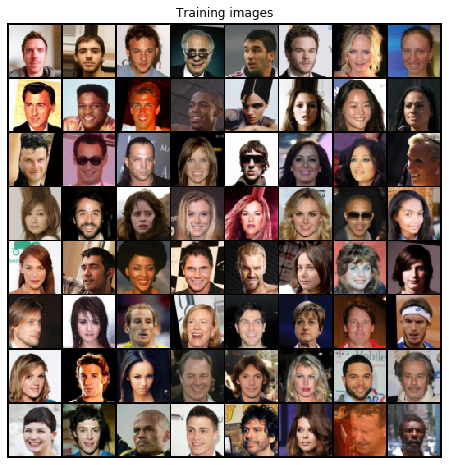

In [0]:
dataset = dset.ImageFolder(root = dataroot,
                          transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                          ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle = True, num_workers= workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 2, normalize=True, ).cpu(),
                        (1,2,0)))

In [0]:
print(torch.cuda.is_available())

True


In [0]:
# weight initialization
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 : 
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1 :
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self,ngpu):
        super(Generator,self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias= False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias = False),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

In [0]:
netG = Generator(ngpu).to(device)

if (device.type == "cuda") and (ngpu >= 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    
netG.apply(weight_init)

print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [0]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator,self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc,ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4,1,0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self,input):
        return self.main(input)

In [0]:
netD = Discriminator(ngpu).to(device)

if (device.type == "cuda") and (ngpu >= 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
netD.apply(weight_init)

print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    

In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

In [0]:
# trainig loop

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training ...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader,0):
        # train real batches
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,),real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output,label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # train fake batches
        noise = torch.randn(b_size, nz, 1, 1, device = device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output,label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i%50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\td(x): %.4f\tD(G(z)): %.4f / %.4f' 
                 % (epoch, num_epochs, i, len(dataloader),
                   errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i==len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding = 2, normalize=True))
                
            iters += 1

Starting Training ...
[0/5][0/1587]	Loss_D: 1.8265	Loss_G: 3.9444	d(x): 0.4169	D(G(z)): 0.4818 / 0.0292
[0/5][50/1587]	Loss_D: 0.2665	Loss_G: 31.4193	d(x): 0.8651	D(G(z)): 0.0000 / 0.0000
[0/5][100/1587]	Loss_D: 0.5414	Loss_G: 13.1259	d(x): 0.8792	D(G(z)): 0.2446 / 0.0000
[0/5][150/1587]	Loss_D: 0.3526	Loss_G: 4.4276	d(x): 0.8231	D(G(z)): 0.0628 / 0.0234
[0/5][200/1587]	Loss_D: 0.3182	Loss_G: 4.9344	d(x): 0.8515	D(G(z)): 0.1111 / 0.0120
[0/5][250/1587]	Loss_D: 0.4743	Loss_G: 4.4529	d(x): 0.7857	D(G(z)): 0.1325 / 0.0229
[0/5][300/1587]	Loss_D: 0.8347	Loss_G: 6.5399	d(x): 0.9147	D(G(z)): 0.4650 / 0.0037
[0/5][350/1587]	Loss_D: 0.5332	Loss_G: 3.8540	d(x): 0.7771	D(G(z)): 0.1634 / 0.0409
[0/5][400/1587]	Loss_D: 0.9233	Loss_G: 5.0959	d(x): 0.7237	D(G(z)): 0.3055 / 0.0112
[0/5][450/1587]	Loss_D: 0.4248	Loss_G: 4.3164	d(x): 0.9031	D(G(z)): 0.2447 / 0.0201
[0/5][500/1587]	Loss_D: 0.5428	Loss_G: 4.3173	d(x): 0.7118	D(G(z)): 0.0407 / 0.0261
[0/5][550/1587]	Loss_D: 0.3998	Loss_G: 4.4923	d(x): 0.9

KeyboardInterrupt: ignored